In [0]:
import pandas as pd
import numpy as np
from pathlib import Path
from fastai import*
from fastai.text import*


## Wrangling

In [92]:
path = Path("")
df = pd.read_csv("IMDB Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [0]:
train_rev = df.loc[10000:14999,'review'].values
train_lab = df.loc[10000:14999,'sentiment'].values
val_rev = df.loc[36000:38999,"review"].values
val_lab = df.loc[36000:38999,"sentiment"].values


np.random.seed(23)
train_ran = np.random.permutation(len(train_rev))
val_ran = np.random.permutation(len(val_rev))

train_rev = train_rev[train_ran]
train_lab = train_lab[train_ran]

val_rev = val_rev[val_ran]
val_lab = val_lab[val_ran]


col_names = ['labels','text']
df_trn = pd.DataFrame({'text':train_rev, 'labels':train_lab}, columns=col_names)
df_val = pd.DataFrame({'text':val_rev, 'labels':val_lab}, columns=col_names)


## Tokenization

In [94]:
import fastai.text.learner as l
data_bunch = l.TextLMDataBunch.from_df(path,train_df=df_trn, valid_df=df_val)


In [95]:
from fastai.text import*
data_bunch.show_batch()

idx,text
0,"i 'm still equally as impressed today with the musical numbers , each one a standout song with wonderfully dramatic lyrics in the epic tradition of 80 's pop ( think xxmaj pat xxmaj xxunk on helium , only xxunk ) . \n \n xxmaj controversy has stirred over the blatantly suggestive tone of the xxmaj xxunk 's song "" xxmaj xxunk ' xxmaj lucky xxmaj with xxmaj you"
1,being updated up to this day as if it was a history book . xxmaj well it 's not . xxmaj the movie is about the novels 1950s version . xxmaj some actors were xxup great but that does n't cover the plot . \n \n xxmaj in short man invents a super - bomb so xxmaj god and his friends hold a tribunal to see if they must
2,"of its laughs ; xxmaj baby xxmaj mama has little going on in any of these departments . xxmaj of course to say that the film is without any value at all would be unfair . i 'm sure female audiences in a similar boat as lead character xxmaj kate may get a slight kick out of the proceedings , but anyone else will probably just feel numb and probably"
3,". xxmaj the black mother declares that it 's "" all right , then "" when it 's mentioned that another black character is at church instead of helping prepare dinner ( because all blacks love church ) , the xxmaj hispanics seem only capable of speaking xxmaj spanish when the greet each other or make exclamations , the lesbians do nothing but xxunk and kiss ( and one of"
4,"story , which got me to thinking . xxmaj with all the dialogue , the minimal locations and the lack of cinematic qualities , it occurred to me that with two kick ass actors and a tightening re - write , xxup two xxup harbors might make a really kick - ass stage play  maybe even a one - act . xxmaj if there are any bold theater producers"


## Numericalization

In [96]:
token = data_bunch.train_ds[0][0].data[:]
len(token)

259

In [0]:
data_bunch.save('tmp_lm')

## Language Model & Encoding 

In [0]:
learner = language_model_learner(data_bunch,AWD_LSTM, pretrained=URLs.WT103_BWD, drop_mult=0.5)

## Learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


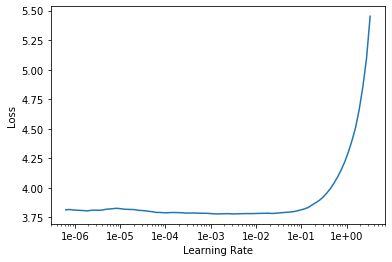

In [112]:
learner.lr_find()
learner.recorder.plot()

## Training and Prediction

In [101]:
learner.fit_one_cycle(2,1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,4.299817,4.046644,0.281628,00:55
1,3.956351,3.975762,0.288265,00:55


In [102]:
learner.predict("All the movies",n_words=10)

'All the movies are long ... - HECK 1 oooooooooo'

In [0]:
learner.save_encoder('fine_enc')

In [105]:
df_trn


,labels,text
0,positive,"To this day, there isn't a movie I've seen mor..."
1,negative,This movie was so bad I couldn't sit through i...
2,positive,A very positive message for our youth is shown...
3,negative,There is no possible reason I can fathom why t...
4,negative,What a HUGE pile of dung. Shot-on-video (REALL...
...,...,...
4995,negative,"Well well, I had seen a lot of reviews on this..."
4996,negative,"Well, what can you say about a Barbara Cartlan..."
4997,negative,"I have three comments to make about this film,..."
4998,positive,"I have one word to someup this movie, WOW! I s..."


## Classifier

In [106]:
data_clas = TextClasDataBunch.from_df(path=path,train_df=df_trn, valid_df=df_val, vocab=data_bunch.train_ds.vocab, bs=36)

In [107]:
classifier = text_classifier_learner(data_clas, arch= AWD_LSTM,drop_mult=0.5,max_len=60000)
classifier.load_encoder('fine_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5000 items)
x: TextList
xxbos xxmaj to this day , there is n't a movie i 've seen more times than xxmaj the xxmaj chipmunk xxmaj adventure , nor has any movie brought me more happiness . xxmaj this is by no means the greatest film or even the greatest animated film , but to an 8 year old girl in 1988 it was the coolest , funniest , most exciting film ever ! i 'm still equally as impressed today with the musical numbers , each one a standout song with wonderfully dramatic lyrics in the epic tradition of 80 's pop ( think xxmaj pat xxmaj xxunk on helium , only xxunk ) . 
 
  xxmaj controversy has stirred over the blatantly suggestive tone of the xxmaj xxunk 's song " xxmaj xxunk ' xxmaj lucky xxmaj with xxmaj you " , which to me seemed much more innocent at the time . xxmaj however , looking at it as a rational adult , i can totally understand the concern ; you 've got three young girls in skimpy xxunk outfits passionately proclaiming

## Finding a Learning Rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


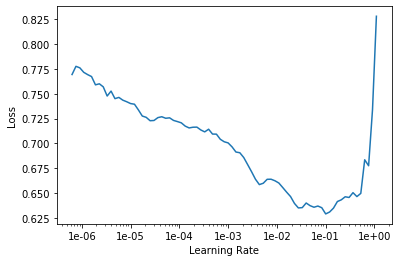

In [108]:
classifier.lr_find()
classifier.recorder.plot()

## Training the Model

In [115]:
classifier.fit_one_cycle(1,1e-03,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.418418,0.345147,0.853667,00:41


In [116]:
classifier.freeze_to(-2)
classifier.fit_one_cycle(2,1e-03,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.425796,0.327024,0.863000,00:45
1,0.350526,0.291253,0.879000,00:43


In [ ]:
## Predicting and Testing our Model

In [176]:
classifier.predict("Reading the book before watching this movie, I was expecting more special effects of the Zone. Yet, Tarkovsky pleasantly surprises me by making this a film more about the human experience than of a post-apocalyptic wasteland.Though artistic, I find the film itself a bit too slow moving for my tastes and had moments where I nearly dozed off.3.5/5. I'd still rate this as one of Tarkovsky's great masterpieces but was a bit slow. Would recommend this for anyone wanting a crash course on Tarkovsky. ")

(Category positive, tensor(1), tensor([0.1531, 0.8469]))

In [177]:
classifier.predict("Reading the book before watching this movie, I was expecting more special effects of the Zone. Yet, Tarkovsky pleasantly surprises me by making this a film more about the human experience than of a post-apocalyptic wasteland.Though artistic, I find the film itself a bit too slow moving for my tastes and had moments where I nearly dozed off.3.5/5. I'd still rate this as one of Tarkovsky's great masterpieces but was a bit slow. ")


(Category positive, tensor(1), tensor([0.1672, 0.8328]))

In [178]:
classifier.predict("Reading the book before watching this movie, I was expecting more special effects of the Zone. Yet, Tarkovsky pleasantly surprises me by making this a film more about the human experience than of a post-apocalyptic wasteland.Though artistic, I find the film itself a bit too slow moving for my tastes and had moments where I nearly dozed off. I'd still rate this as one of Tarkovsky's great masterpieces but was a bit slow. ")


(Category positive, tensor(1), tensor([0.1252, 0.8748]))

In [179]:
classifier.predict("Reading the book before watching this movie, I was expecting more special effects of the Zone. Yet, Tarkovsky pleasantly surprises me by making this a film more about the human experience than of a post-apocalyptic wasteland.Though artistic, I find the film itself a bit too slow moving for my tastes and had moments where I nearly dozed off.  but was a bit slow. ")


(Category positive, tensor(1), tensor([0.0969, 0.9031]))

In [181]:
classifier.predict("Reading the book before watching this movie, I was expecting more special effects of the Zone. Tarkovsky surprises me by making this a film more about the human experience than of a post-apocalyptic wasteland.Though artistic, I find the film itself a bit too slow moving for my tastes and had moments where I nearly dozed off.  but was a bit slow. ")


(Category positive, tensor(1), tensor([0.1437, 0.8563]))

In [182]:
classifier.predict("Reading the book before watching this movie, I was expecting more special effects of the Zone. this a film more about the human experience than of a post-apocalyptic wasteland.Though artistic, I find the film itself a bit too slow moving for my tastes and had moments where I nearly dozed off.  but was a bit slow. ")


(Category positive, tensor(1), tensor([0.2594, 0.7406]))

In [183]:
classifier.predict("Reading the book before watching this movie, I was expecting more special effects of the Zone. Though artistic, I find the film itself a bit too slow moving for my tastes and had moments where I nearly dozed off.  but was a bit slow. ")


(Category positive, tensor(1), tensor([0.4219, 0.5781]))

In [185]:
classifier.predict(", . Though artistic, I find the film itself a bit too slow moving for my tastes and had moments where I nearly dozed off.  but was a bit slow. ")


(Category negative, tensor(0), tensor([0.5043, 0.4957]))